# CAN


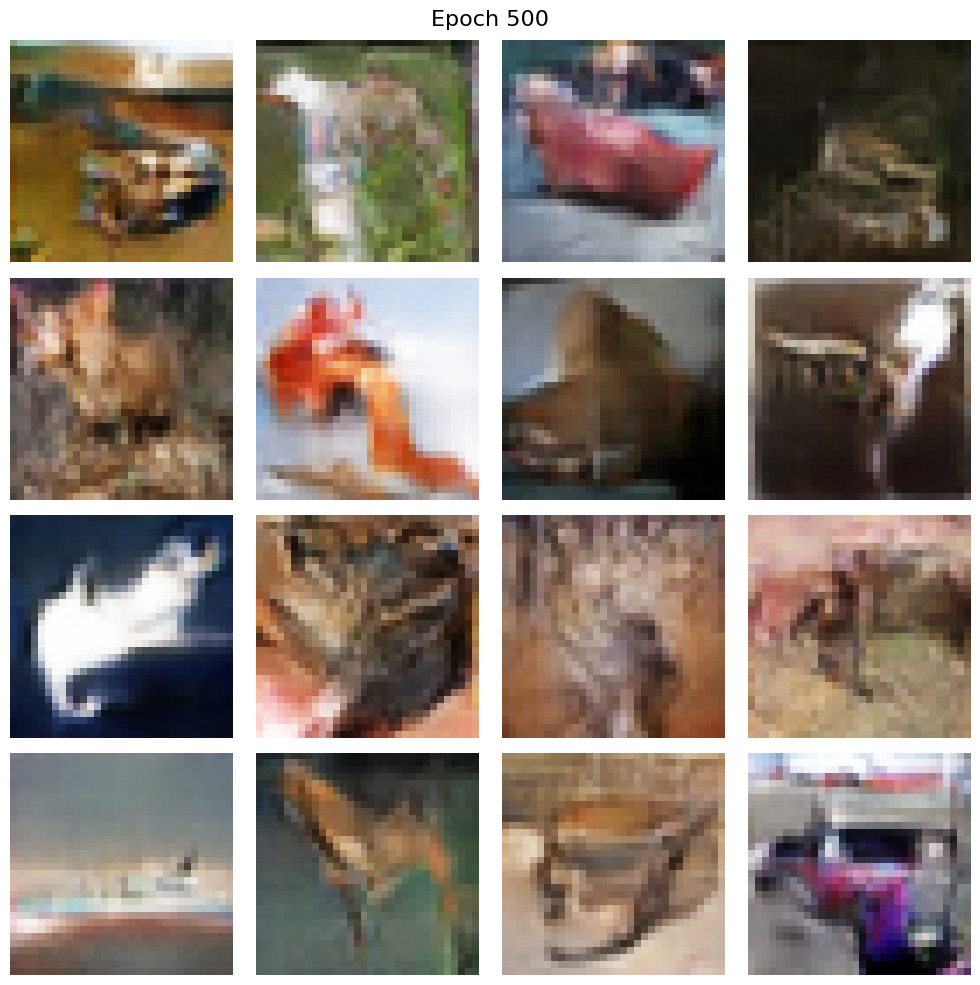

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 96 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

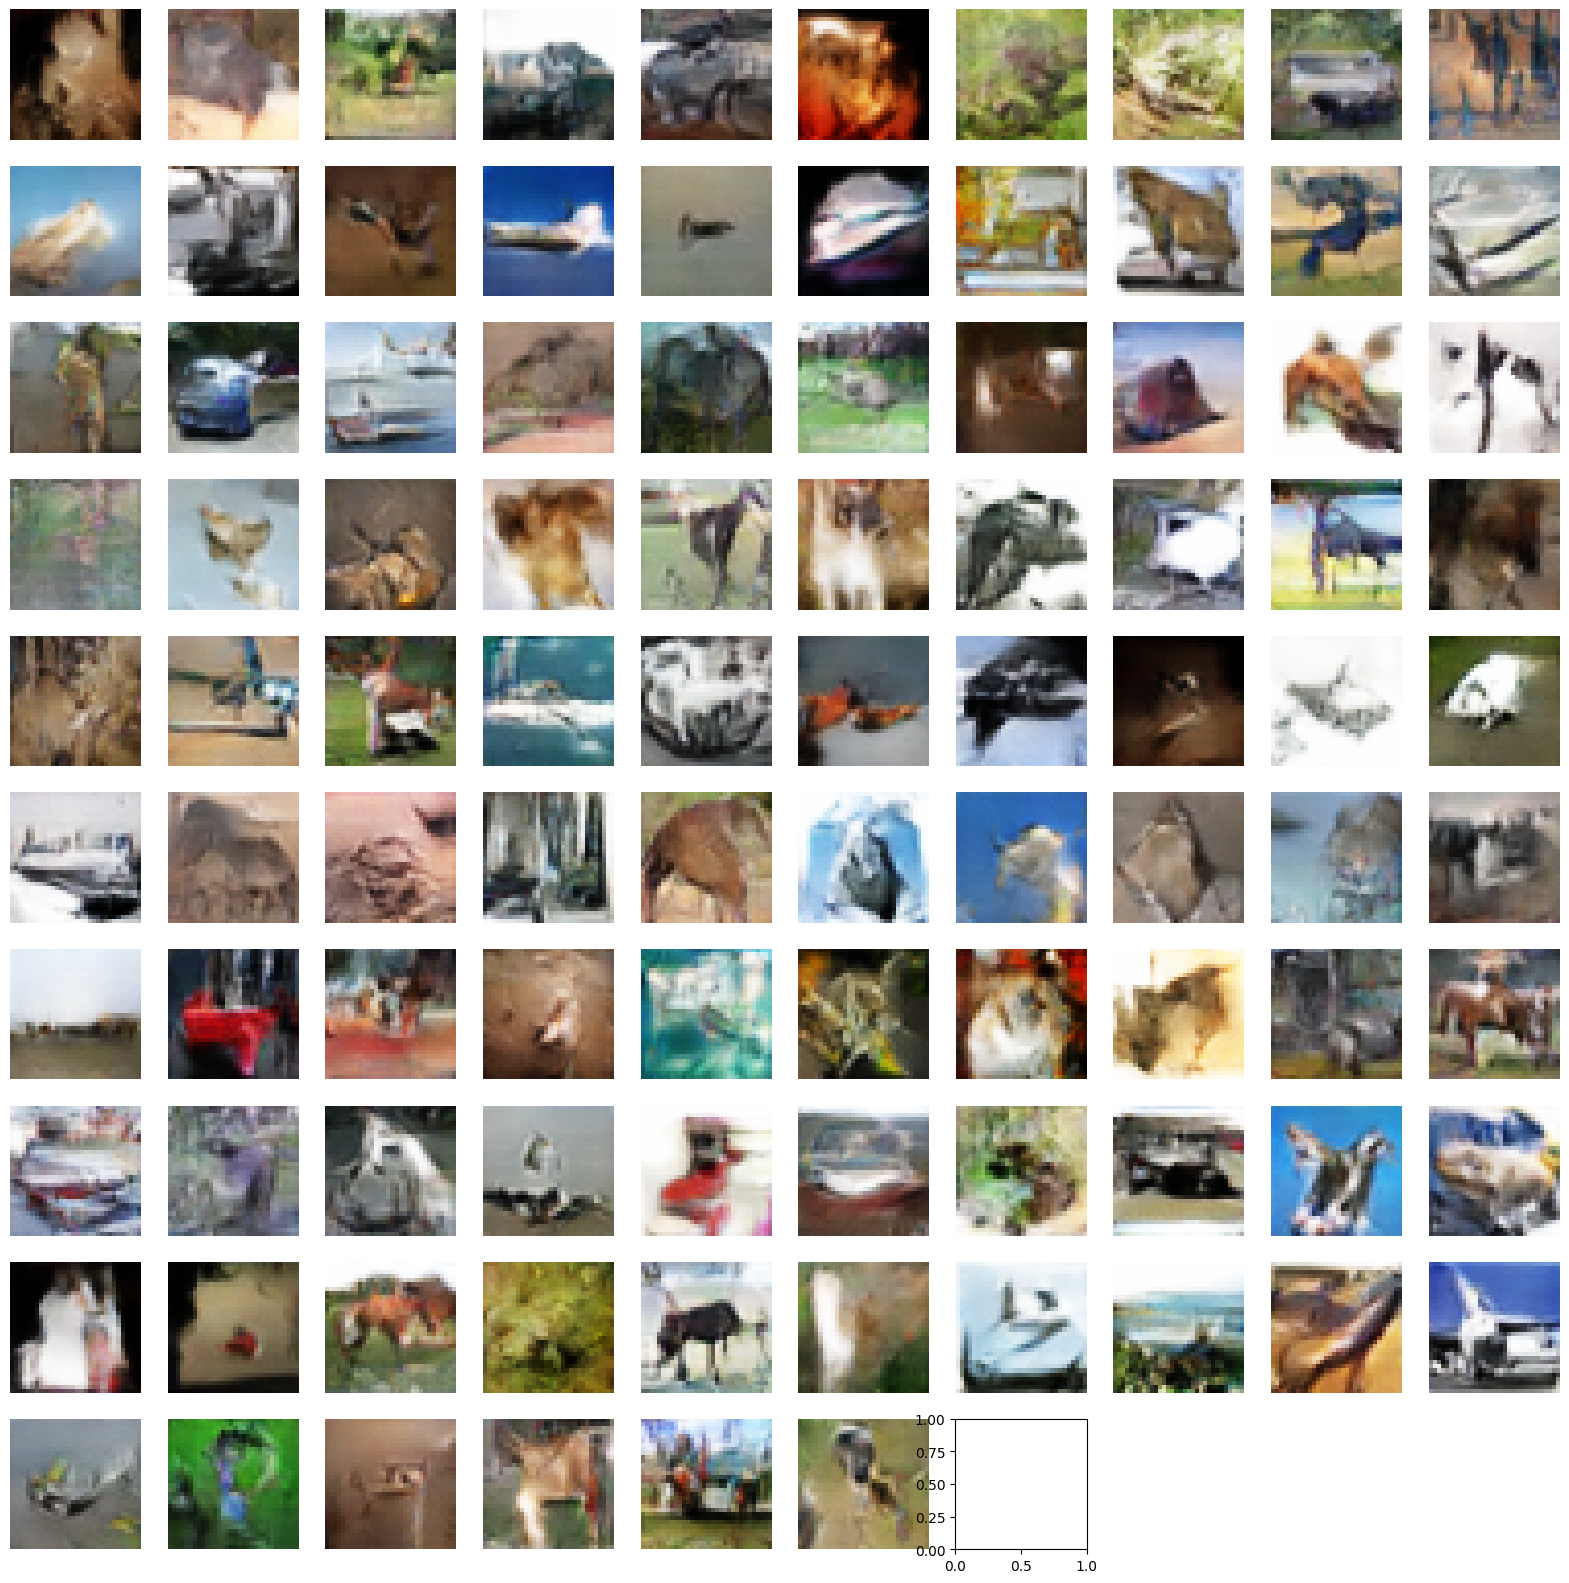

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display
from tensorflow.keras import layers, models

(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

# Normalize the images to [-1, 1]
train_images = (train_images.astype('float32') - 127.5) / 127.5

# Convert labels to one-hot encoding (these will be our "style" classes)
train_labels = tf.keras.utils.to_categorical(train_labels, 10)

# Create tf.data.Dataset
BUFFER_SIZE = 50000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create generator model
def make_generator_model():
    """Creates the generator model based on DCGAN architecture."""
    model = models.Sequential()

    # Start with a dense layer that takes in the noise
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Reshape into a 4x4x256 tensor
    model.add(layers.Reshape((4, 4, 256)))

    # Upsample to 8x8
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsample to 16x16
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsample to 32x32 (CIFAR-10 size)
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# Create discriminator model with two outputs (real/fake and style classification)
def make_discriminator_model():
    """Creates the discriminator with two outputs: real/fake and style classification."""
    # Input image
    img_input = layers.Input(shape=(32, 32, 3))

    # Common body of convolutional layers
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(img_input)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Flatten()(x)

    # Real/fake output
    real_fake_output = layers.Dense(1)(x)

    # Style classification output (10 classes for CIFAR-10)
    style_output = layers.Dense(10, activation='softmax')(x)

    # Create the model with two outputs
    model = models.Model(inputs=img_input, outputs=[real_fake_output, style_output])

    return model

# Loss functions and optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Binary cross-entropy loss for real/fake discrimination
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Categorical cross-entropy loss for style classification
categorical_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Define discriminator loss
def discriminator_loss(real_output, fake_output, real_style_output, real_style_labels):
    """Loss function for the discriminator.

    Args:
        real_output: Real/fake predictions for real images
        fake_output: Real/fake predictions for fake images
        real_style_output: Style predictions for real images
        real_style_labels: True style labels for real images

    Returns:
        Dictionary with individual losses and total loss
    """
    # Real/fake loss for real images
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # Real/fake loss for fake images
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # Combine real/fake losses
    real_fake_loss = real_loss + fake_loss

    # Style classification loss for real images
    style_loss = categorical_cross_entropy(real_style_labels, real_style_output)

    # Total discriminator loss
    total_loss = real_fake_loss + style_loss

    # Return dictionary of losses for monitoring
    return {
        'total': total_loss,
        'real_fake': real_fake_loss,
        'style': style_loss
    }

# Define generator loss
def generator_loss(fake_output, fake_style_output):
    """Loss function for the generator.

    Args:
        fake_output: Real/fake predictions for fake images
        fake_style_output: Style predictions for fake images

    Returns:
        Total generator loss
    """
    # Real/fake loss (trying to fool the discriminator)
    real_fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    # Style ambiguity loss using cross-entropy with uniform distribution
    # This is the key innovation of CAN compared to standard GAN
    # As described in the paper, using cross-entropy instead of entropy
    # provides a hefty penalty if any class probability approaches 1

    # Create uniform target distribution (1/K for each class)
    num_classes = tf.shape(fake_style_output)[-1]
    uniform_target = tf.ones_like(fake_style_output) / tf.cast(num_classes, tf.float32)

    # Compute cross-entropy between the uniform distribution and style predictions
    # We want to minimize this cross-entropy to maximize style ambiguity
    style_ambiguity_loss = categorical_cross_entropy(uniform_target, fake_style_output)

    # Total generator loss: fool discriminator while maximizing style ambiguity
    total_loss = real_fake_loss + style_ambiguity_loss

    return total_loss

# Training step
@tf.function
def train_step(images, labels):
    """Performs one training step.

    Args:
        images: Batch of real images
        labels: Batch of style labels for real images

    Returns:
        Dictionary of generator and discriminator loss values
    """
    # Generate random noise for the generator
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)

        # Get discriminator outputs for real and fake images
        real_output, real_style_output = discriminator(images, training=True)
        fake_output, fake_style_output = discriminator(generated_images, training=True)

        # Calculate losses
        gen_loss = generator_loss(fake_output, fake_style_output)
        disc_losses = discriminator_loss(real_output, fake_output, real_style_output, labels)

    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_losses['total'], discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return {
        'generator': gen_loss,
        'discriminator': disc_losses
    }

# Function to generate and display images
def generate_and_display_images(model, epoch, test_input):
    """Generates and displays images from the model.

    Args:
        model: Generator model
        epoch: Current epoch number
        test_input: Random noise vector
    """
    # Generate images from the test input
    predictions = model(test_input, training=False)

    plt.figure(figsize=(10, 10))

    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)  # Rescale from [-1, 1] to [0, 1]
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Function to save generated images
def save_generated_images(model, epoch, test_input, count=16):
    """Saves generated images to disk.

    Args:
        model: Generator model
        epoch: Current epoch number
        test_input: Random noise vector
        count: Number of images to generate
    """
    # For regular checkpoints, use the seed
    if count == 16:
        predictions = model(test_input, training=False)

        plt.figure(figsize=(10, 10))

        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
            plt.axis('off')

        plt.suptitle(f'Epoch {epoch}', fontsize=16)
        plt.tight_layout()
        plt.savefig(f'can_epoch_{epoch}.png')
        plt.close()

    # For final results, generate more images
    else:
        num_batches = count // 16
        all_images = []

        for _ in range(num_batches):
            noise = tf.random.normal([16, 100])
            predictions = model(noise, training=False)
            all_images.append(predictions)

        # Combine all batches
        all_images = tf.concat(all_images, axis=0)

        # Create a grid of images
        rows = int(np.sqrt(count))
        cols = count // rows

        plt.figure(figsize=(cols*2, rows*2))

        for i in range(count):
            plt.subplot(rows, cols, i+1)
            plt.imshow(all_images[i, :, :, :] * 0.5 + 0.5)
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(f'can_final_images.png')
        plt.close()

# Training function
def train(dataset, epochs):
    """Trains the CAN model for the specified number of epochs.

    Args:
        dataset: Training dataset
        epochs: Number of epochs to train for
    """
    # Lists to store loss values for plotting
    gen_losses = []
    disc_total_losses = []
    disc_realfake_losses = []
    disc_style_losses = []

    for epoch in range(epochs):
        start = time.time()

        epoch_gen_loss = 0
        epoch_disc_total_loss = 0
        epoch_disc_realfake_loss = 0
        epoch_disc_style_loss = 0
        batches = 0

        for image_batch, label_batch in dataset:
            loss_dict = train_step(image_batch, label_batch)

            # Accumulate losses
            epoch_gen_loss += loss_dict['generator']
            epoch_disc_total_loss += loss_dict['discriminator']['total']
            epoch_disc_realfake_loss += loss_dict['discriminator']['real_fake']
            epoch_disc_style_loss += loss_dict['discriminator']['style']

            batches += 1

        # Calculate average losses for the epoch
        epoch_gen_loss /= batches
        epoch_disc_total_loss /= batches
        epoch_disc_realfake_loss /= batches
        epoch_disc_style_loss /= batches

        # Add to lists for plotting
        gen_losses.append(epoch_gen_loss)
        disc_total_losses.append(epoch_disc_total_loss)
        disc_realfake_losses.append(epoch_disc_realfake_loss)
        disc_style_losses.append(epoch_disc_style_loss)

        # Display progress
        display.clear_output(wait=True)
        generate_and_display_images(generator, epoch + 1, seed)

        # Save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            save_generated_images(generator, epoch + 1, seed)

        # Print status
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Generator Loss: {epoch_gen_loss:.4f}')
        print(f'Discriminator Total Loss: {epoch_disc_total_loss:.4f}')
        print(f'   - Real/Fake Loss: {epoch_disc_realfake_loss:.4f}')
        print(f'   - Style Loss: {epoch_disc_style_loss:.4f}')
        print(f'Time for epoch {epoch+1}: {time.time()-start:.2f} sec')

    # Display final results
    display.clear_output(wait=True)
    generate_and_display_images(generator, epochs, seed)

    # Save final generated images
    save_generated_images(generator, epochs, seed, count=100)

    # Save the models
    generator.save('can_generator.h5')
    discriminator.save('can_discriminator.h5')

    # Plot loss curves
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_total_losses, label='Discriminator Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Overall Losses')

    plt.subplot(2, 1, 2)
    plt.plot(disc_realfake_losses, label='Discriminator Real/Fake Loss')
    plt.plot(disc_style_losses, label='Discriminator Style Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Discriminator Component Losses')

    plt.tight_layout()
    plt.savefig('can_loss_curves.png')
    plt.show()

# Create the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Generate seed noise for visualization
seed = tf.random.normal([16, 100])

# Train the CAN model
EPOCHS = 500  # Adjust based on available computational resources
train(train_dataset, EPOCHS)

# Comparative GAN

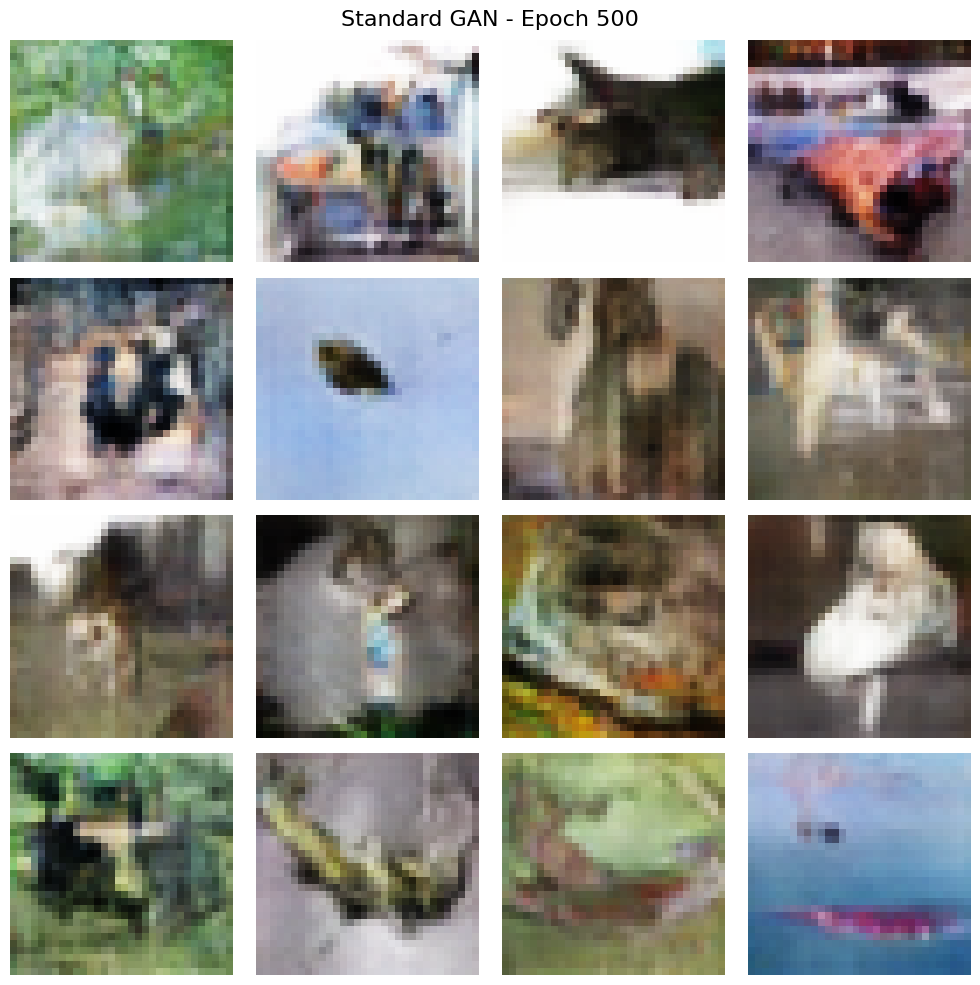

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 96 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

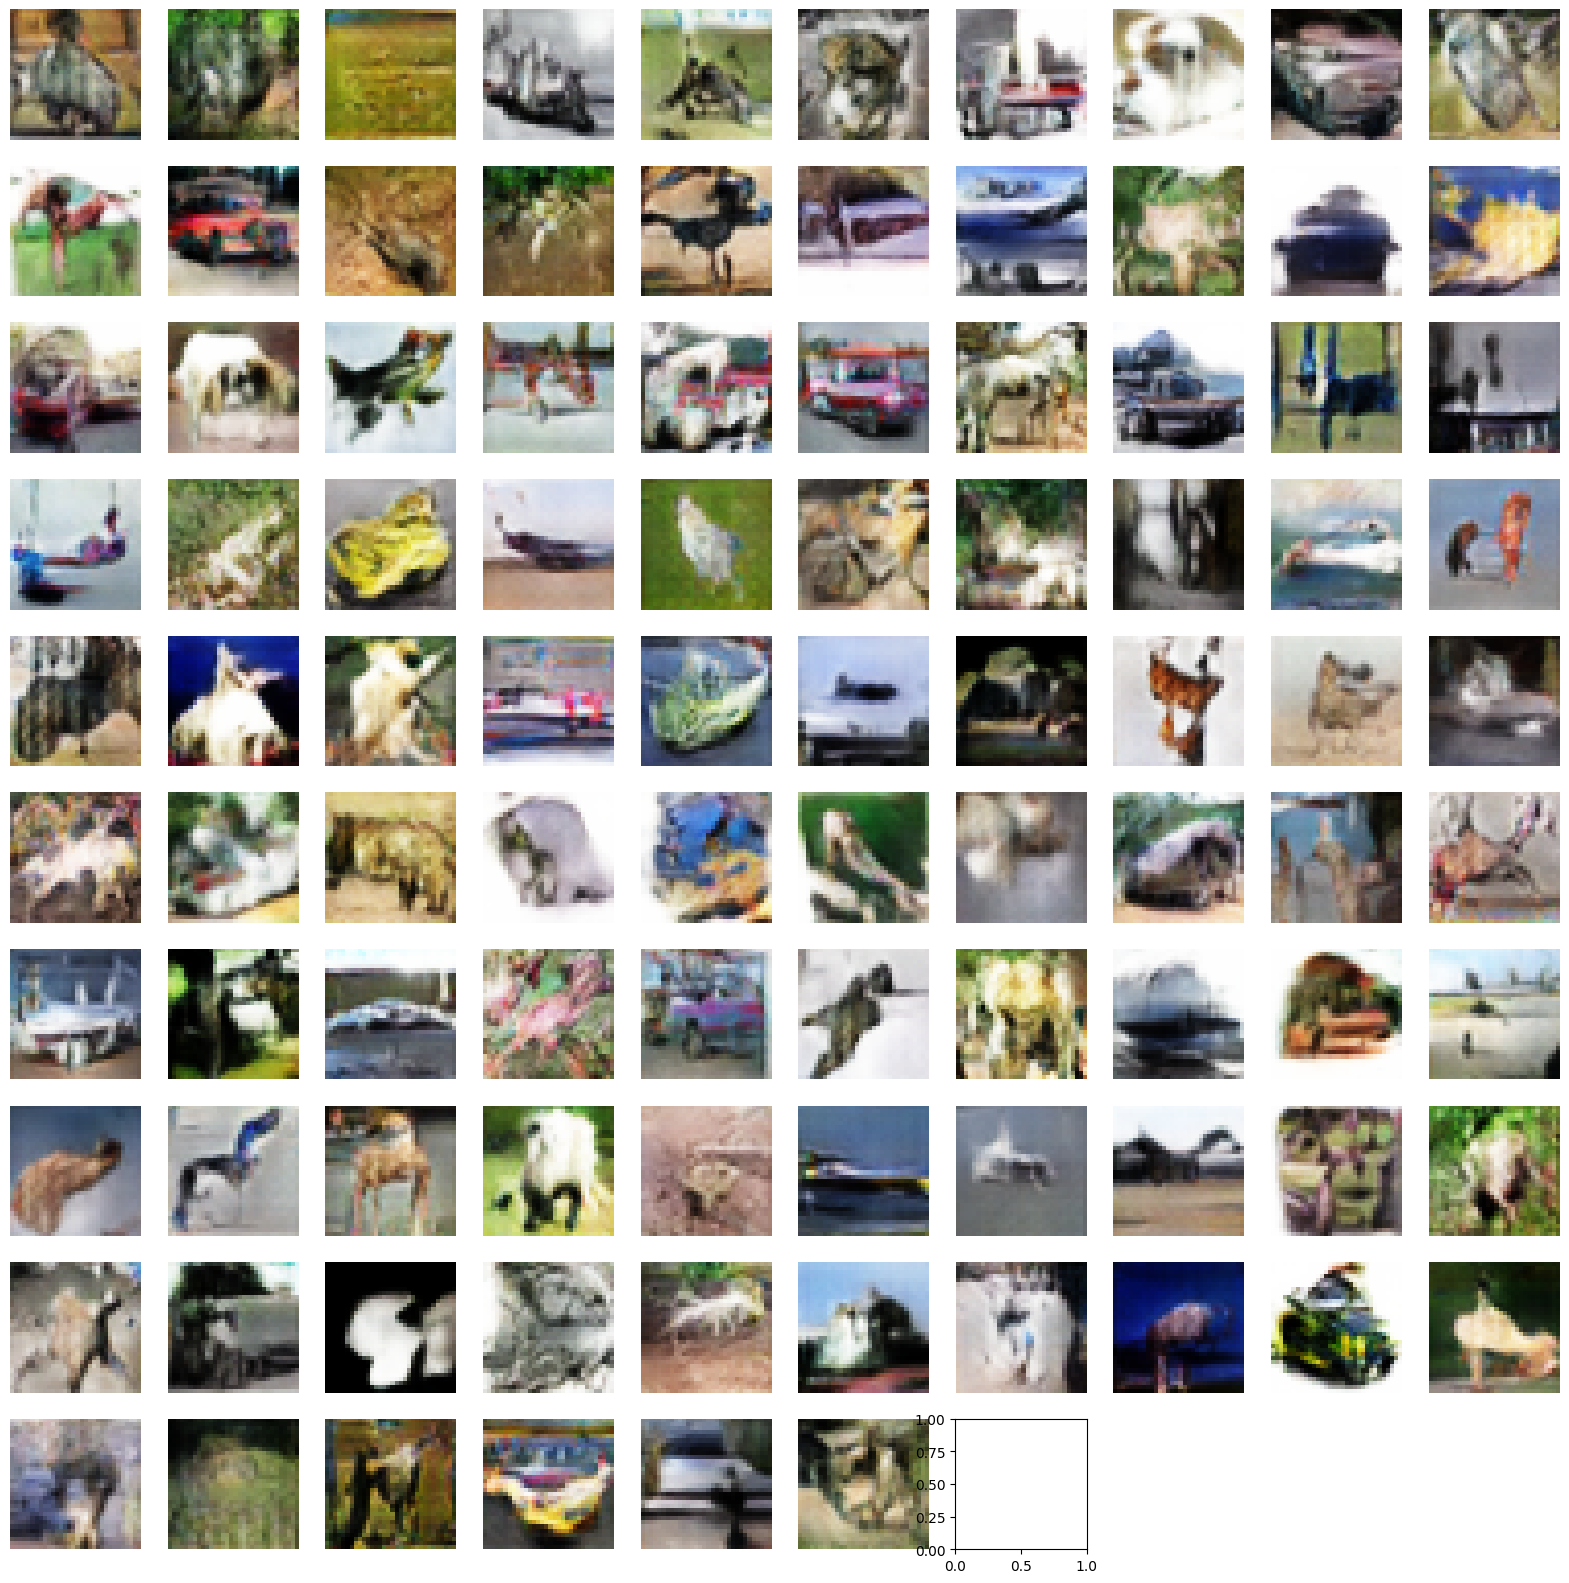

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display
from tensorflow.keras import layers, models

# Load CIFAR-10 dataset
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()

# Normalize the images to [-1, 1]
train_images = (train_images.astype('float32') - 127.5) / 127.5

# Create tf.data.Dataset
BUFFER_SIZE = 50000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Define the generator model (same as in CAN)
def make_generator_model():
    """Creates the generator model based on DCGAN architecture."""
    model = models.Sequential()

    # Start with a dense layer that takes in the noise
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Reshape into a 4x4x256 tensor
    model.add(layers.Reshape((4, 4, 256)))

    # Upsample to 8x8
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsample to 16x16
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsample to 32x32 (CIFAR-10 size)
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# Define the discriminator model - only real/fake classification (no style)
def make_discriminator_model():
    """Creates a standard discriminator for GAN that only classifies real/fake."""
    model = models.Sequential()

    # First convolutional layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second convolutional layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Third convolutional layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Flatten and output layer (single output for real/fake)
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Define loss functions and optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Binary cross-entropy loss for real/fake discrimination
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define discriminator loss
def discriminator_loss(real_output, fake_output):
    """Standard GAN discriminator loss function.

    Args:
        real_output: Discriminator predictions for real images
        fake_output: Discriminator predictions for fake images

    Returns:
        Total discriminator loss
    """
    # Real loss (label=1)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # Fake loss (label=0)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # Total loss
    total_loss = real_loss + fake_loss

    return total_loss

# Define generator loss
def generator_loss(fake_output):
    """Standard GAN generator loss function.

    Args:
        fake_output: Discriminator predictions for fake images

    Returns:
        Generator loss
    """
    # Generator tries to fool discriminator (label=1)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Training step
@tf.function
def train_step(images):
    """Performs one training step.

    Args:
        images: Batch of real images

    Returns:
        Generator and discriminator loss values
    """
    # Generate random noise for the generator
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)

        # Get discriminator outputs for real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Function to generate and display images
def generate_and_display_images(model, epoch, test_input):
    """Generates and displays images from the model.

    Args:
        model: Generator model
        epoch: Current epoch number
        test_input: Random noise vector
    """
    # Generate images from the test input
    predictions = model(test_input, training=False)

    plt.figure(figsize=(10, 10))

    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)  # Rescale from [-1, 1] to [0, 1]
        plt.axis('off')

    plt.suptitle(f'Standard GAN - Epoch {epoch}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Function to save generated images
def save_generated_images(model, epoch, test_input, count=16):
    """Saves generated images to disk.

    Args:
        model: Generator model
        epoch: Current epoch number
        test_input: Random noise vector
        count: Number of images to generate
    """
    # For regular checkpoints, use the seed
    if count == 16:
        predictions = model(test_input, training=False)

        plt.figure(figsize=(10, 10))

        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
            plt.axis('off')

        plt.suptitle(f'Standard GAN - Epoch {epoch}', fontsize=16)
        plt.tight_layout()
        plt.savefig(f'gan_epoch_{epoch}.png')
        plt.close()

    # For final results, generate more images
    else:
        num_batches = count // 16
        all_images = []

        for _ in range(num_batches):
            noise = tf.random.normal([16, 100])
            predictions = model(noise, training=False)
            all_images.append(predictions)

        # Combine all batches
        all_images = tf.concat(all_images, axis=0)

        # Create a grid of images
        rows = int(np.sqrt(count))
        cols = count // rows

        plt.figure(figsize=(cols*2, rows*2))

        for i in range(count):
            plt.subplot(rows, cols, i+1)
            plt.imshow(all_images[i, :, :, :] * 0.5 + 0.5)
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(f'gan_final_images.png')
        plt.close()

# Training function
def train(dataset, epochs):
    """Trains the GAN model for the specified number of epochs.

    Args:
        dataset: Training dataset
        epochs: Number of epochs to train for
    """
    # Lists to store loss values for plotting
    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        start = time.time()

        epoch_gen_loss = 0
        epoch_disc_loss = 0
        batches = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            batches += 1

        # Calculate average losses for the epoch
        epoch_gen_loss /= batches
        epoch_disc_loss /= batches

        # Add to lists for plotting
        gen_losses.append(epoch_gen_loss)
        disc_losses.append(epoch_disc_loss)

        # Display progress
        display.clear_output(wait=True)
        generate_and_display_images(generator, epoch + 1, seed)

        # Save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            save_generated_images(generator, epoch + 1, seed)

        # Print status
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Generator Loss: {epoch_gen_loss:.4f}, Discriminator Loss: {epoch_disc_loss:.4f}')
        print(f'Time for epoch {epoch+1}: {time.time()-start:.2f} sec')

    # Display final results
    display.clear_output(wait=True)
    generate_and_display_images(generator, epochs, seed)

    # Save final generated images
    save_generated_images(generator, epochs, seed, count=100)

    # Save the models
    generator.save('gan_generator.h5')
    discriminator.save('gan_discriminator.h5')

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Standard GAN Loss Curves')
    plt.savefig('gan_loss_curve.png')
    plt.show()

# Create the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Generate seed noise for visualization
seed = tf.random.normal([16, 100])

# Set number of epochs
EPOCHS = 500  # Adjust based on available computational resources

# Train the standard GAN model
train(train_dataset, EPOCHS)

# CAN - robot movements

In [13]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import time
from IPython import display

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create results directory
save_dir = 'robot_can_results'
os.makedirs(save_dir, exist_ok=True)

# Function to load all robot movement sequences from different folders
def load_movement_data(base_folder='robot_movements', category_folders=None):
    """
    Load robot movement data from multiple folders, each representing a category/style.

    Args:
        base_folder: Base directory containing category folders
        category_folders: List of category folder names (if None, use all folders)

    Returns:
        movements: List of movement sequences
        labels: List of category labels
        category_map: Dictionary mapping category names to indices
    """
    if category_folders is None:
        # Get all subdirectories in the base folder
        category_folders = [d for d in os.listdir(base_folder)
                           if os.path.isdir(os.path.join(base_folder, d))]

    print(f"Found {len(category_folders)} movement categories: {category_folders}")

    # Create a mapping from category names to indices
    category_map = {cat: idx for idx, cat in enumerate(category_folders)}

    movements = []
    labels = []

    # Load movements from each category folder
    for category in category_folders:
        folder_path = os.path.join(base_folder, category)

        # Get all CSV files in the folder
        csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

        print(f"Found {len(csv_files)} movement files in category '{category}'")

        # Load each movement file
        for file in csv_files:
            try:
                df = pd.read_csv(file)

                # Extract joint position columns
                position_cols = [col for col in df.columns if 'Position' in col]
                if not position_cols:
                    position_cols = df.columns[:7]  # Assume first 7 columns are positions if not labeled

                # Extract the positions
                positions = df[position_cols].values

                # Check for NaN values
                if np.isnan(positions).any():
                    print(f"Warning: NaN values found in {file}, filling with zeros")
                    positions = np.nan_to_num(positions)

                # Add to movements and labels
                movements.append(positions)
                labels.append(category_map[category])

            except Exception as e:
                print(f"Error loading {file}: {str(e)}")

    print(f"Successfully loaded {len(movements)} movement sequences across {len(category_folders)} categories")
    return movements, labels, category_map

# Preprocess robot movement data
def preprocess_movement_data(movements, labels, seq_length=128, step_size=64):
    """
    Preprocess robot movement data for the CAN.

    Args:
        movements: List of movement sequences
        labels: List of category labels
        seq_length: Length of sequences to use (pad/truncate to this length)
        step_size: Step size for sliding window when creating training examples

    Returns:
        X_train: Movement sequences
        y_train: One-hot encoded labels
        scaler: Fitted scaler for inverse transformation
    """
    # Use RobustScaler which is less sensitive to outliers
    scaler = RobustScaler()

    # Lists for processed data
    processed_sequences = []
    processed_labels = []

    # Process each movement sequence
    for mov, label in zip(movements, labels):
        # Skip if too short
        if len(mov) < seq_length // 2:
            print(f"Warning: Sequence too short ({len(mov)} frames), skipping")
            continue

        # Fit scaler on the first sequence, then just transform
        if len(processed_sequences) == 0:
            scaled_mov = scaler.fit_transform(mov)
        else:
            scaled_mov = scaler.transform(mov)

        # Clip extreme values after scaling
        scaled_mov = np.clip(scaled_mov, -3.0, 3.0)

        # Create sliding windows if sequence is long enough
        if len(scaled_mov) >= seq_length:
            for start_idx in range(0, len(scaled_mov) - seq_length + 1, step_size):
                window = scaled_mov[start_idx:start_idx + seq_length]
                processed_sequences.append(window)
                processed_labels.append(label)
        else:
            # Pad shorter sequences
            padded_seq = np.zeros((seq_length, scaled_mov.shape[1]))
            padded_seq[:len(scaled_mov)] = scaled_mov
            processed_sequences.append(padded_seq)
            processed_labels.append(label)

    # Convert to numpy arrays
    X_train = np.array(processed_sequences)
    labels_array = np.array(processed_labels)

    # Convert labels to one-hot encoding
    num_classes = len(np.unique(labels_array))
    y_train = tf.keras.utils.to_categorical(labels_array, num_classes)

    print(f"Preprocessed data shape: {X_train.shape}, Labels shape: {y_train.shape}")
    return X_train, y_train, scaler

# Create generator model for robot movements
def make_generator_model(latent_dim=100, seq_length=128, num_features=7):
    """
    Creates the generator model for robot movements.

    Args:
        latent_dim: Dimension of the latent space
        seq_length: Length of output sequence
        num_features: Number of features per timestep (joint positions)

    Returns:
        Generator model
    """
    model = models.Sequential()

    # Start with dense layers to process the latent vector
    model.add(layers.Dense(256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(512, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Reshape to prepare for sequence generation
    model.add(layers.Dense(seq_length * 32, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((seq_length, 32)))

    # Add LSTM layers for sequence modeling
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
    model.add(layers.Dropout(0.2))

    # Final layer to generate movement sequences
    model.add(layers.TimeDistributed(layers.Dense(num_features, activation='tanh')))

    return model

# Create discriminator model with two outputs (real/fake and style classification)
def make_discriminator_model(seq_length=128, num_features=7, num_classes=3):
    """
    Creates the discriminator with two outputs: real/fake and style classification.

    Args:
        seq_length: Length of input sequence
        num_features: Number of features per timestep (joint positions)
        num_classes: Number of movement categories

    Returns:
        Discriminator model
    """
    # Input sequence
    seq_input = layers.Input(shape=(seq_length, num_features))

    # Bidirectional LSTMs to process the sequence
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(seq_input)
    x = layers.Dropout(0.2)(x)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)

    # Global pooling to get a fixed-size representation
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers for feature extraction
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)

    # Real/fake output
    real_fake_output = layers.Dense(1)(x)

    # Style classification output
    style_output = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model with two outputs
    model = models.Model(inputs=seq_input, outputs=[real_fake_output, style_output])

    return model

# Loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
categorical_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Define discriminator loss
def discriminator_loss(real_output, fake_output, real_style_output, real_style_labels):
    """Loss function for the discriminator."""
    # Real/fake loss for real sequences
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # Real/fake loss for fake sequences
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # Combine real/fake losses
    real_fake_loss = real_loss + fake_loss

    # Style classification loss for real sequences
    style_loss = categorical_cross_entropy(real_style_labels, real_style_output)

    # Total discriminator loss
    total_loss = real_fake_loss + style_loss

    return {
        'total': total_loss,
        'real_fake': real_fake_loss,
        'style': style_loss
    }


def temporal_smoothness_loss(sequences):
    """Calculate first and second derivatives to penalize non-smooth movements"""
    # First derivatives (velocities)
    velocities = sequences[:, 1:, :] - sequences[:, :-1, :]
    # Second derivatives (accelerations)
    accelerations = velocities[:, 1:, :] - velocities[:, :-1, :]

    # Calculate sum of squared derivatives
    vel_loss = tf.reduce_mean(tf.square(velocities))
    acc_loss = tf.reduce_mean(tf.square(accelerations))

    return vel_loss + 0.5 * acc_loss

# Define generator loss
def generator_loss(fake_output, fake_style_output):
    """Loss function for the generator."""
    # Real/fake loss (trying to fool the discriminator)
    real_fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    # Style ambiguity loss using cross-entropy with uniform distribution
    # This is the key innovation of CAN
    num_classes = tf.shape(fake_style_output)[-1]
    uniform_target = tf.ones_like(fake_style_output) / tf.cast(num_classes, tf.float32)

    # Compute cross-entropy between uniform distribution and style predictions
    # We want to minimize this to maximize style ambiguity
    style_ambiguity_loss = categorical_cross_entropy(uniform_target, fake_style_output)

    # Total generator loss: fool discriminator while maximizing style ambiguity
    total_loss = real_fake_loss + style_ambiguity_loss

    return total_loss


# def generator_loss(fake_output, fake_style_output, generated_sequences, smoothness_weight=0.1):
#     # Original CAN loss
#     real_fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

#     # Style ambiguity loss
#     num_classes = tf.shape(fake_style_output)[-1]
#     uniform_target = tf.ones_like(fake_style_output) / tf.cast(num_classes, tf.float32)
#     style_ambiguity_loss = categorical_cross_entropy(uniform_target, fake_style_output)

#     # Add smoothness loss
#     smoothness = temporal_smoothness_loss(generated_sequences)

#     # Combine losses
#     total_loss = real_fake_loss + style_ambiguity_loss + smoothness_weight * smoothness

#     return total_loss

# Training step
@tf.function
def train_step(sequences, labels, generator, discriminator,
              generator_optimizer, discriminator_optimizer, batch_size, latent_dim):
    """Performs one training step."""
    # Generate random noise for the generator
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake sequences
        generated_sequences = generator(noise, training=True)

        # Get discriminator outputs for real and fake sequences
        real_output, real_style_output = discriminator(sequences, training=True)
        fake_output, fake_style_output = discriminator(generated_sequences, training=True)

        # Calculate losses
        gen_loss = generator_loss(fake_output, fake_style_output)
        disc_losses = discriminator_loss(real_output, fake_output, real_style_output, labels)

    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_losses['total'], discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return {
        'generator': gen_loss,
        'discriminator': disc_losses
    }

# Function to plot generated movement sequences
def plot_movement_sequence(sequence, title, filename, num_joints=7):
    """
    Plot a generated movement sequence for visualization.

    Args:
        sequence: Generated movement sequence
        title: Plot title
        filename: Output filename
        num_joints: Number of joints to plot
    """
    plt.figure(figsize=(15, 10))

    # Plot position for each joint
    for i in range(num_joints):
        plt.subplot(num_joints, 1, i+1)
        plt.plot(sequence[:, i], linewidth=2)
        plt.title(f'Joint {i+1} Position')
        plt.grid(True, alpha=0.3)

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

# Function to generate and display movement sequences
def generate_movement_sequences(model, scaler, num_sequences=4, latent_dim=100, seq_length=128, num_features=7):
    """
    Generate and return movement sequences from the model.

    Args:
        model: Generator model
        scaler: Scaler for inverse transformation
        num_sequences: Number of sequences to generate
        latent_dim: Dimension of the latent space
        seq_length: Length of output sequence
        num_features: Number of features per timestep

    Returns:
        Generated sequences (after inverse scaling)
    """
    # Generate random noise
    noise = tf.random.normal([num_sequences, latent_dim])

    # Generate sequences
    generated_sequences = model(noise, training=False).numpy()

    # Inverse scale to get back to original range
    rescaled_sequences = np.zeros_like(generated_sequences)

    for i in range(num_sequences):
        rescaled_sequences[i] = scaler.inverse_transform(generated_sequences[i])

    return rescaled_sequences

# Function to save generated movement sequences as CSV
def save_movement_sequences(sequences, base_filename, folder=save_dir):
    """
    Save generated movement sequences as CSV files.

    Args:
        sequences: List of movement sequences
        base_filename: Base filename for saving
        folder: Folder to save in
    """
    os.makedirs(folder, exist_ok=True)

    for i, seq in enumerate(sequences):
        # Create a DataFrame
        column_names = [f'Position{j+1}' for j in range(seq.shape[1])]
        df = pd.DataFrame(seq, columns=column_names)

        # Save to CSV
        output_path = os.path.join(folder, f"{base_filename}_{i+1}.csv")
        df.to_csv(output_path, index=False)
        print(f"Saved sequence to {output_path}")

# Main function to train and generate robot movements
def train_robot_can(base_folder='robot_movements', category_folders=None,
                   seq_length=128, latent_dim=100, batch_size=32, epochs=100):
    """
    Train the CAN model and generate robot movements.

    Args:
        base_folder: Base directory containing category folders
        category_folders: List of category folder names
        seq_length: Sequence length to use
        latent_dim: Dimension of the latent space
        batch_size: Batch size for training
        epochs: Number of epochs to train
    """
    # Load and preprocess data
    print("Loading movement data...")
    movements, labels, category_map = load_movement_data(base_folder, category_folders)

    num_classes = len(category_map)
    print(f"Number of movement categories: {num_classes}")

    print("Preprocessing movement data...")
    X_train, y_train, scaler = preprocess_movement_data(movements, labels, seq_length)

    num_features = X_train.shape[2]
    print(f"Number of features per timestep: {num_features}")

    # Create the dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size)

    # Create models
    print("Creating models...")
    generator = make_generator_model(latent_dim, seq_length, num_features)
    discriminator = make_discriminator_model(seq_length, num_features, num_classes)

    # Print model summaries
    generator.summary()
    discriminator.summary()

    # Create optimizers
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

    # Create seed for visualization
    seed = tf.random.normal([4, latent_dim])

    # Lists to store loss values
    gen_losses = []
    disc_total_losses = []
    disc_realfake_losses = []
    disc_style_losses = []

    print(f"Starting training for {epochs} epochs...")
    for epoch in range(epochs):
        start_time = time.time()

        epoch_gen_loss = 0
        epoch_disc_total_loss = 0
        epoch_disc_realfake_loss = 0
        epoch_disc_style_loss = 0
        batches = 0

        for seq_batch, label_batch in train_dataset:
            loss_dict = train_step(
                seq_batch, label_batch,
                generator, discriminator,
                generator_optimizer, discriminator_optimizer,
                batch_size, latent_dim
            )

            # Accumulate losses
            epoch_gen_loss += loss_dict['generator']
            epoch_disc_total_loss += loss_dict['discriminator']['total']
            epoch_disc_realfake_loss += loss_dict['discriminator']['real_fake']
            epoch_disc_style_loss += loss_dict['discriminator']['style']

            batches += 1

        # Calculate average losses
        epoch_gen_loss /= batches
        epoch_disc_total_loss /= batches
        epoch_disc_realfake_loss /= batches
        epoch_disc_style_loss /= batches

        # Add to loss history
        gen_losses.append(epoch_gen_loss)
        disc_total_losses.append(epoch_disc_total_loss)
        disc_realfake_losses.append(epoch_disc_realfake_loss)
        disc_style_losses.append(epoch_disc_style_loss)

        # Generate and save example sequences every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            generated_sequences = generate_movement_sequences(
                generator, scaler, num_sequences=4,
                latent_dim=latent_dim, seq_length=seq_length, num_features=num_features
            )

            # Plot the first sequence
            plot_movement_sequence(
                generated_sequences[0],
                f"Generated Movement Sequence (Epoch {epoch+1})",
                os.path.join(save_dir, f"sequence_epoch_{epoch+1}.png"),
                num_joints=num_features
            )

            # Save sequences as CSV
            save_movement_sequences(
                generated_sequences,
                f"generated_epoch_{epoch+1}",
                folder=save_dir
            )

        # Print progress
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Generator Loss: {epoch_gen_loss:.4f}")
        print(f"Discriminator Total Loss: {epoch_disc_total_loss:.4f}")
        print(f"   - Real/Fake Loss: {epoch_disc_realfake_loss:.4f}")
        print(f"   - Style Loss: {epoch_disc_style_loss:.4f}")
        print(f"Time for epoch {epoch+1}: {time.time()-start_time:.2f} sec")
        print()

        # Save models every 20 epochs
        if (epoch + 1) % 20 == 0:
            generator.save(os.path.join(save_dir, f"generator_epoch_{epoch+1}.h5"))
            discriminator.save(os.path.join(save_dir, f"discriminator_epoch_{epoch+1}.h5"))

    # Final models
    generator.save(os.path.join(save_dir, "generator_final.h5"))
    discriminator.save(os.path.join(save_dir, "discriminator_final.h5"))

    # Plot loss curves
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_total_losses, label='Discriminator Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Overall Losses')

    plt.subplot(2, 1, 2)
    plt.plot(disc_realfake_losses, label='Discriminator Real/Fake Loss')
    plt.plot(disc_style_losses, label='Discriminator Style Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Discriminator Component Losses')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'loss_curves.png'))
    plt.close()

    print("Training complete!")

    # Generate final sequences
    print("Generating final movement sequences...")
    final_sequences = generate_movement_sequences(
        generator, scaler, num_sequences=10,
        latent_dim=latent_dim, seq_length=seq_length, num_features=num_features
    )

    # Save final sequences
    save_movement_sequences(final_sequences, "final_sequence", folder=save_dir)

    # Plot some of the final sequences
    for i in range(min(4, len(final_sequences))):
        plot_movement_sequence(
            final_sequences[i],
            f"Final Generated Movement Sequence #{i+1}",
            os.path.join(save_dir, f"final_sequence_{i+1}.png"),
            num_joints=num_features
        )

    print(f"All results saved to {save_dir}")
    return generator, discriminator, scaler

# If you want to evaluate how "creative" the generated movements are
def evaluate_creativity(discriminator, sequences, scaler, num_classes):
    """
    Evaluate how "creative" the generated movements are by checking their style ambiguity.

    Args:
        discriminator: Trained discriminator model
        sequences: Generated sequences to evaluate
        scaler: Scaler used during training
        num_classes: Number of movement categories

    Returns:
        creativity_scores: List of creativity scores for each sequence
    """
    # Scale the sequences
    scaled_sequences = np.array([scaler.transform(seq) for seq in sequences])

    # Get style predictions from discriminator
    _, style_predictions = discriminator.predict(scaled_sequences)

    # Calculate entropy for each prediction (higher entropy = more ambiguous = more creative)
    entropies = []
    for pred in style_predictions:
        # Calculate entropy: -sum(p * log(p))
        entropy = -np.sum(pred * np.log(pred + 1e-10))
        # Normalize by maximum possible entropy (uniform distribution)
        max_entropy = np.log(num_classes)
        normalized_entropy = entropy / max_entropy
        entropies.append(normalized_entropy)

    # Higher entropy means more ambiguous style classification (more creative)
    return entropies

# Add a function to verify that the generated movements are physically plausible
def check_movement_constraints(sequences, joint_limits=None):
    """
    Check if generated movements satisfy physical constraints.

    Args:
        sequences: Generated movement sequences
        joint_limits: List of (min, max) tuples for each joint

    Returns:
        valid_sequences: List of boolean values indicating if each sequence is valid
    """
    if joint_limits is None:
        # Default joint limits (adjust based on your robot)
        joint_limits = [(-2.0, 2.0)] * sequences[0].shape[1]

    valid_sequences = []

    for seq in sequences:
        # Check joint limits
        joints_within_limits = True
        for j in range(seq.shape[1]):
            min_val, max_val = joint_limits[j]
            if np.any(seq[:, j] < min_val) or np.any(seq[:, j] > max_val):
                joints_within_limits = False
                break

        # Check for sudden jumps (first derivative)
        velocities = np.diff(seq, axis=0)
        max_velocity = np.max(np.abs(velocities))
        smooth_motion = max_velocity < 0.5  # Adjust threshold as needed

        # Check for jerky movements (second derivative)
        accelerations = np.diff(velocities, axis=0)
        max_acceleration = np.max(np.abs(accelerations))
        smooth_acceleration = max_acceleration < 0.3  # Adjust threshold as needed

        # Sequence is valid if it satisfies all constraints
        is_valid = joints_within_limits and smooth_motion and smooth_acceleration
        valid_sequences.append(is_valid)

    return valid_sequences

# Example usage
if __name__ == "__main__":
    # Define your category folders
    categories = ["dance", "embrace", "public"]

    # Train the model
    generator, discriminator, scaler = train_robot_can(
        base_folder='robot_movements',
        category_folders=categories,
        seq_length=1200,
        latent_dim=100,
        batch_size=32,
        epochs=10
    )

    # Generate new creative movements
    generated_movements = generate_movement_sequences(
        generator, scaler, num_sequences=10,
        latent_dim=100, seq_length=128, num_features=7
    )

    # Evaluate creativity
    creativity_scores = evaluate_creativity(discriminator, generated_movements, scaler, len(categories))
    print("Creativity scores (higher is more creative):", creativity_scores)

    # Check physical plausibility
    valid_movements = check_movement_constraints(generated_movements)
    print("Valid movements:", valid_movements)

    # Save the most creative and valid movements
    creative_valid_indices = [i for i, (score, valid) in enumerate(zip(creativity_scores, valid_movements))
                             if valid and score > 0.7]  # Adjust threshold as needed

    if creative_valid_indices:
        creative_valid_movements = [generated_movements[i] for i in creative_valid_indices]
        save_movement_sequences(creative_valid_movements, "creative_valid_movement", folder=save_dir)
        print(f"Saved {len(creative_valid_movements)} creative and valid movements")

Loading movement data...
Found 3 movement categories: ['dance', 'embrace', 'public']
Found 42 movement files in category 'dance'
Found 18 movement files in category 'embrace'
Found 50 movement files in category 'public'
Successfully loaded 110 movement sequences across 3 categories
Number of movement categories: 3
Preprocessing movement data...
Preprocessed data shape: (796, 1200, 7), Labels shape: (796, 3)
Number of features per timestep: 7
Creating models...


/opt/anaconda3/envs/tensorflow_macos/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/tensorflow_macos/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 256)            │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 38400)          │    19,660,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 38400)          │       153,600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 1200, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 1200, 128)      │        49,664 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1200, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 1200, 7)        │           903 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,711 (76.39 MB)

 Trainable params: 19,946,375 (76.09 MB)

 Non-trainable params: 78,336 (306.00 KB)

Model: "functional_69"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1200, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_13    │ (None, 1200, 128) │     36,864 │ input_layer_9[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 1200, 128) │          0 │ bidirectional_13… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_14    │ (None, 1200, 128) │     98,816 │ dropout_17[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 1200, 128) │          0 │ bidirectional_14… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ dropout_18[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 256)       │     33,024 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_19      │ (None, 256)       │          0 │ dense_32[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 256)       │          0 │ leaky_re_lu_19[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 1)         │        257 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 3)         │        771 │ dropout_19[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 169,732 (663.02 KB)

 Trainable params: 169,732 (663.02 KB)

 Non-trainable params: 0 (0.00 B)

Starting training for 10 epochs...


2025-05-19 15:42:14.339091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Saved sequence to robot_can_results/generated_epoch_1_1.csv
Saved sequence to robot_can_results/generated_epoch_1_2.csv
Saved sequence to robot_can_results/generated_epoch_1_3.csv
Saved sequence to robot_can_results/generated_epoch_1_4.csv
Epoch 1/10
Generator Loss: 1.7946
Discriminator Total Loss: 2.1824
   - Real/Fake Loss: 1.2554
   - Style Loss: 0.9270
Time for epoch 1: 233.37 sec



2025-05-19 15:43:56.104647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/10
Generator Loss: 1.7375
Discriminator Total Loss: 1.8725
   - Real/Fake Loss: 1.1365
   - Style Loss: 0.7360
Time for epoch 2: 85.57 sec



2025-05-19 15:45:05.107634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3/10
Generator Loss: 1.7002
Discriminator Total Loss: 1.7494
   - Real/Fake Loss: 1.1242
   - Style Loss: 0.6252
Time for epoch 3: 69.00 sec



2025-05-19 15:46:09.752645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/10
Generator Loss: 1.8497
Discriminator Total Loss: 1.5250
   - Real/Fake Loss: 0.9883
   - Style Loss: 0.5367
Time for epoch 4: 64.64 sec



2025-05-19 15:47:14.721461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5/10
Generator Loss: 2.0285
Discriminator Total Loss: 1.1976
   - Real/Fake Loss: 0.7465
   - Style Loss: 0.4512
Time for epoch 5: 64.97 sec



2025-05-19 15:48:20.681031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6/10
Generator Loss: 1.9874
Discriminator Total Loss: 1.0614
   - Real/Fake Loss: 0.6907
   - Style Loss: 0.3706
Time for epoch 6: 65.99 sec



2025-05-19 15:49:24.175036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7/10
Generator Loss: 2.1612
Discriminator Total Loss: 0.8559
   - Real/Fake Loss: 0.5486
   - Style Loss: 0.3073
Time for epoch 7: 63.47 sec



2025-05-19 15:50:28.191369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8/10
Generator Loss: 2.8592
Discriminator Total Loss: 0.6382
   - Real/Fake Loss: 0.3636
   - Style Loss: 0.2746
Time for epoch 8: 64.02 sec



2025-05-19 15:51:31.011344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9/10
Generator Loss: 3.3009
Discriminator Total Loss: 0.5360
   - Real/Fake Loss: 0.3018
   - Style Loss: 0.2343
Time for epoch 9: 62.81 sec



2025-05-19 15:52:33.216280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Saved sequence to robot_can_results/generated_epoch_10_1.csv
Saved sequence to robot_can_results/generated_epoch_10_2.csv
Saved sequence to robot_can_results/generated_epoch_10_3.csv
Saved sequence to robot_can_results/generated_epoch_10_4.csv
Epoch 10/10
Generator Loss: 3.9199
Discriminator Total Loss: 0.4172
   - Real/Fake Loss: 0.2107
   - Style Loss: 0.2066
Time for epoch 10: 68.56 sec



Training complete!
Generating final movement sequences...
Saved sequence to robot_can_results/final_sequence_1.csv
Saved sequence to robot_can_results/final_sequence_2.csv
Saved sequence to robot_can_results/final_sequence_3.csv
Saved sequence to robot_can_results/final_sequence_4.csv
Saved sequence to robot_can_results/final_sequence_5.csv
Saved sequence to robot_can_results/final_sequence_6.csv
Saved sequence to robot_can_results/final_sequence_7.csv
Saved sequence to robot_can_results/final_sequence_8.csv
Saved sequence to robot_can_results/final_sequence_9.csv
Saved sequence to robot_can_results/final_sequence_10.csv
All results saved to robot_can_results
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
Creativity scores (higher is more creative): [0.693189056407418, 0.73837658676479, 0.8094983038620772, 0.7739685602610191, 0.6547746017983029, 0.7149411988756943, 0.7871650958512715, 0.7192198703864785, 0.8062116756234826, 0.7772783551650347]
Valid movements: [True, True, True, True, True, Tr

In [14]:
!mjpython /Users/pszkw/mujoco_panda/mujoco_panda/paused_movement_no_vel.py /Users/pszkw/robot_can_results/final_sequence_3.csv

9068.76s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Starting playback...
